<a href="https://colab.research.google.com/github/GaryM02/applied_predictive_analytics/blob/main/XAI_vit_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PredictiveAnalyticsProject')

#Visualization Techniques

Saliency Maps: Highlight which parts of the input image contributed most to the prediction.

Grad-CAM (Gradient-weighted Class Activation Mapping): Provide a heatmap overlay on images to visualize where the model is focusing.

Integrated Gradients: Attribute the model’s output to its input features by integrating gradients.

##All Model Templates

In [ ]:
import torch
import torch.nn as nn
import timm
import numpy as np
from skimage.feature import graycomatrix, graycoprops

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, backbone_name=None):
        """
        Siamese network with a single backbone.

        Args:
            backbone1_name (str): Name of the backbone (e.g., 'resnet50').
            embedding_dim (int): Dimension of the output embeddings.
        """
        super(SiameseNetwork, self).__init__()

        # Initialize backbone 1 if provided
        if backbone_name:
            self.backbone = timm.create_model(backbone_name, pretrained=True)
            self.backbone.reset_classifier(0)  # Remove classification head
        else:
            raise ValueError("A backbone model must be specified.")

    def forward(self, input1, input2=None, input3=None):
        """
        Forward pass for one, two, or three inputs.

        Args:
            input1 (torch.Tensor): Anchor input.
            input2 (torch.Tensor, optional): Positive input.
            input3 (torch.Tensor, optional): Negative input.

        Returns:
            Embeddings (torch.Tensor): Embedding of the input(s).
        """


        if input2 is None and input3 is None:
            return self.backbone(input1)

        if input3 is None:
            return self.backbone(input1), self.backbone(input2)

        return self.backbone(input1), self.backbone(input2), self.backbone(input3)

class SiameseNetworkWithGLCM(nn.Module):
    def __init__(self, backbone_name=None, glcm_params=None):
        """
        Siamese network with a single backbone and GLCM feature extraction.

        Args:
            backbone_name (str): Name of the backbone (e.g., 'resnet50').
            glcm_params (dict, optional): Parameters for GLCM feature extraction.
        """
        super(SiameseNetworkWithGLCM, self).__init__()

        # Initialize backbone
        if backbone_name:
            self.backbone = timm.create_model(backbone_name, pretrained=True)
            self.backbone.reset_classifier(0)  # Remove classification head
            self.embedding_dim = self.backbone.num_features
        else:
            raise ValueError("A backbone model must be specified.")

        # Default GLCM parameters
        self.glcm_params = glcm_params or {
            'distances': [1],
            'angles': [0],
            'levels': 256
        }

        # Fully connected layer to combine backbone and GLCM features
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim + 4, 256),  # Combine backbone features + 4 GLCM features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)  # Reduce combined features to final embedding size
        )

    def compute_glcm_features(self, image, device):
        """
        Compute GLCM features (contrast, correlation, energy, homogeneity) from the image.
        Args:
            image (torch.Tensor): Grayscale image (shape: [H, W]).
            device (torch.device): The device to move the output tensor to.
        Returns:
            torch.Tensor: GLCM features as a vector (shape: [4]).
        """
        # Convert tensor to NumPy array
        image_np = image.detach().cpu().numpy()
        # Normalize image to [0, 255] range
        image_np = np.clip(image_np, 0, self.glcm_params['levels'] - 1).astype(np.uint8)

        # Compute GLCM
        glcm = graycomatrix(
            image_np,
            distances=self.glcm_params['distances'],
            angles=self.glcm_params['angles'],
            levels=self.glcm_params['levels'],
            symmetric=True,
            normed=True
        )

        # Extract GLCM properties
        contrast = graycoprops(glcm, 'contrast').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
        energy = graycoprops(glcm, 'energy').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()

        # Return as a tensor on the correct device
        return torch.tensor([contrast, correlation, energy, homogeneity], dtype=torch.float32, device=device)

    def process_input(self, x, device):
        """
        Process a single input through the backbone and compute combined features with GLCM.
        Args:
            x (torch.Tensor): Input tensor (shape: [batch_size, 3, H, W]).
            device (torch.device): Device for tensor operations.
        Returns:
            torch.Tensor: Combined feature vector (shape: [batch_size, 128]).
        """
        # Backbone features
        backbone_features = self.backbone(x)  # Shape: (batch_size, embedding_dim)

        # Compute GLCM features for each image in the batch
        glcm_features = torch.stack([
            self.compute_glcm_features(x[i].mean(dim=0), device)  # Convert to grayscale and compute GLCM
            for i in range(x.size(0))
        ])  # Shape: (batch_size, 4)

        # Combine backbone and GLCM features
        combined_features = torch.cat((backbone_features, glcm_features), dim=1)  # Shape: (batch_size, embedding_dim + 4)

        # Final embedding
        return self.fc(combined_features)  # Shape: (batch_size, 128)

    def forward(self, input1, input2=None, input3=None):
        """
        Forward pass for one, two, or three inputs.
        Args:
            input1 (torch.Tensor): Anchor input.
            input2 (torch.Tensor, optional): Positive input.
            input3 (torch.Tensor, optional): Negative input.
        Returns:
            torch.Tensor or Tuple[torch.Tensor]: Embeddings of the input(s).
        """
        device = input1.device

        # Process single input
        if input2 is None and input3 is None:
            return self.process_input(input1, device)

        # Process two inputs
        if input3 is None:
            embedding1 = self.process_input(input1, device)
            embedding2 = self.process_input(input2, device)
            return embedding1, embedding2

        # Process three inputs
        embedding1 = self.process_input(input1, device)
        embedding2 = self.process_input(input2, device)
        embedding3 = self.process_input(input3, device)
        return embedding1, embedding2, embedding3




In [ ]:
import random

def get_one_image_per_class(root_dir):
    """
    Get one image path from each class folder in the specified root directory.

    Args:
        root_dir (str): Root directory containing subdirectories for each class.

    Returns:
        dict: A dictionary mapping class names to one image path from each class folder.
    """
    if not os.path.exists(root_dir):
        raise ValueError(f"Root directory {root_dir} does not exist.")
    if len(os.listdir(root_dir)) == 0:
        raise ValueError(f"Root directory {root_dir} is empty.")

    class_to_image = {}

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            images = [
                os.path.join(class_path, f)
                for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ]
            if images:
                # Randomly select one image from the folder
                selected_image = random.choice(images)
                class_to_image[class_name] = selected_image

    return class_to_image

# Example usage
root_dir = "data/test"
class_to_image = get_one_image_per_class(root_dir)

# Print the selected image paths
for class_name, image_path in class_to_image.items():
    print(f"Class: {class_name}, Image: {image_path}")


Class: Viral Infections, Image: data/test/Viral Infections/t-herpes-cutaneous-40.jpg
Class: Basal Cell Carcinoma, Image: data/test/Basal Cell Carcinoma/ISIC_0034143.jpg
Class: Benign Keratosis-like Lesions, Image: data/test/Benign Keratosis-like Lesions/ISIC_0056687.jpg
Class: Eczema, Image: data/test/Eczema/t-eczema-nummular-123.jpg
Class: Fungal Infection, Image: data/test/Fungal Infection/t-tinea-incognito-30.jpg
Class: Benign Tumor, Image: data/test/Benign Tumor/t-seborrheic-keratosis-irritated-29.jpg
Class: Psoriasis, Image: data/test/Psoriasis/t-Lichen-Sclerosus-Skin-121.jpg
Class: Melanoma, Image: data/test/Melanoma/ISIC_7218890.jpg
Class: Atopic Dermatitis, Image: data/test/Atopic Dermatitis/6_40.jpg
Class: Melanocytic Nevi, Image: data/test/Melanocytic Nevi/ISIC_0015176_downsampled.jpg


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Saliency Map

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt

glcm_params = {
    'distances': [1, 2],
    'angles': [0],
    'levels': 32
}

# Load model
vit_model = SiameseNetworkWithGLCM(
    backbone_name="vit_base_patch16_224_in21k",
    glcm_params=glcm_params
)
checkpoint = torch.load("siamese_best_model.pth")
vit_model.load_state_dict(checkpoint["model_state_dict"])
vit_model.to(device)
vit_model.eval()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
<ipython-input-46-bb3c78ba7136>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

SiameseNetworkWithGLCM(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approx

(224, 224)


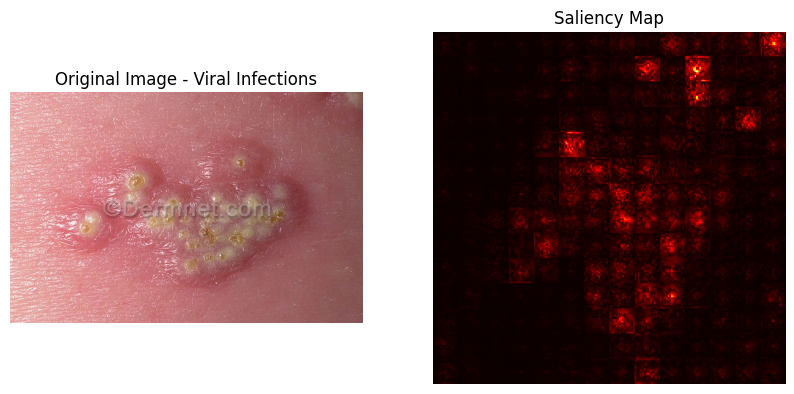

(224, 224)


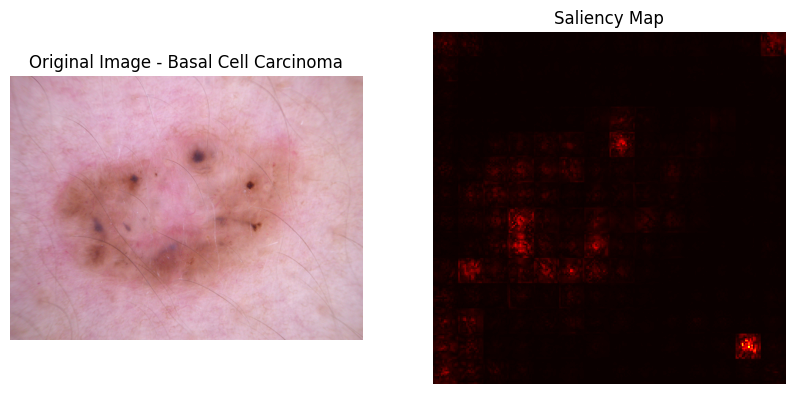

(224, 224)


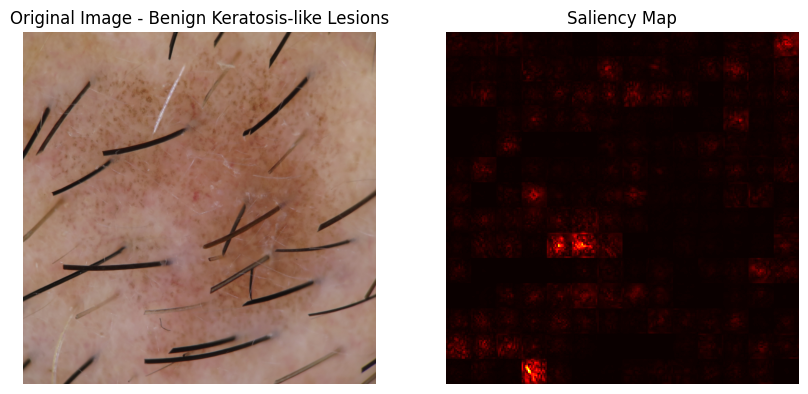

(224, 224)


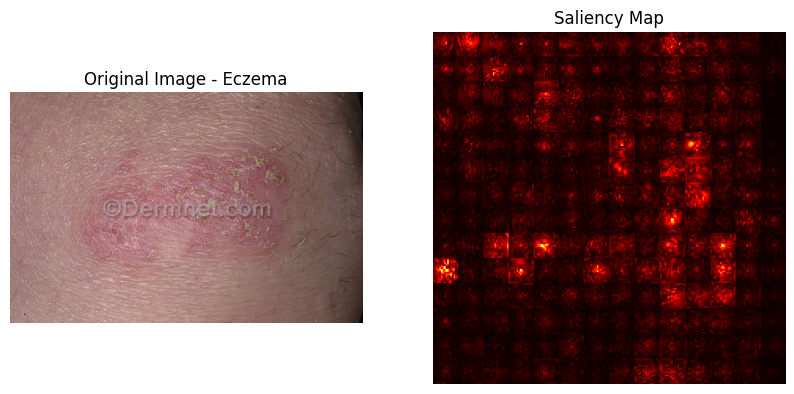

(224, 224)


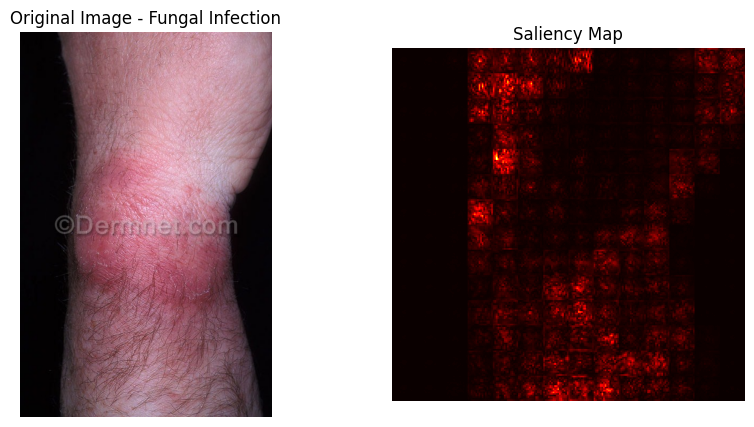

(224, 224)


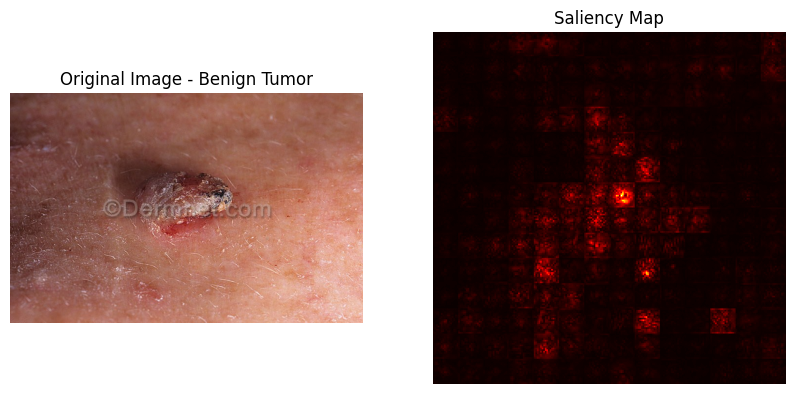

(224, 224)


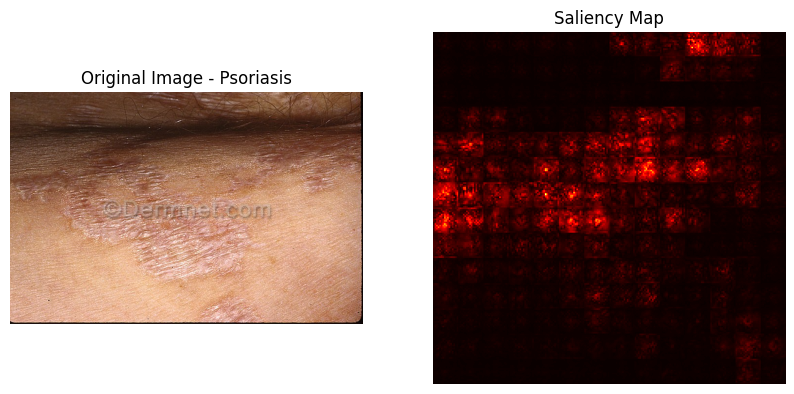

(224, 224)


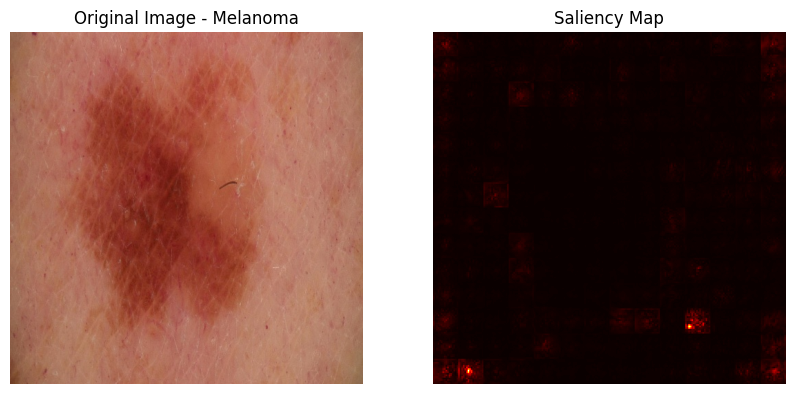

(224, 224)


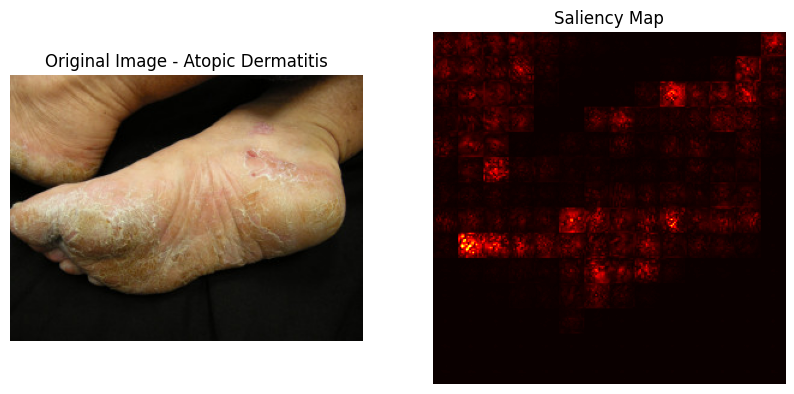

(224, 224)


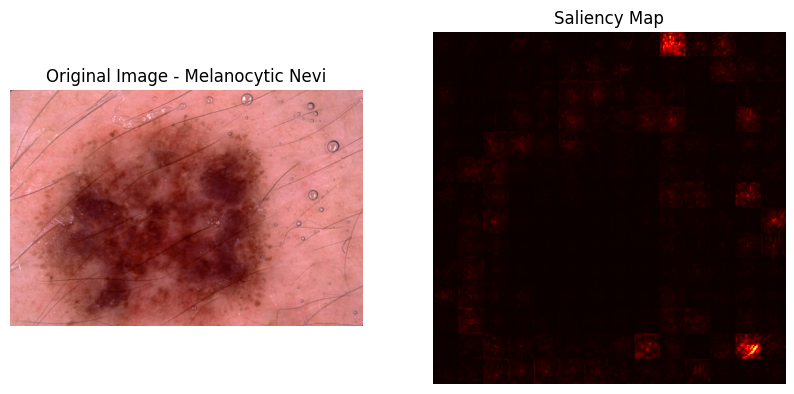

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess image
def preprocess_image(image_path):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Compute saliency map
def compute_saliency_map(model, image_tensor, target_class):
    image_tensor.requires_grad = True

    with torch.amp.autocast(device_type="cuda"):  # Use correct device type
        embedding = model(image_tensor)

    # Define a scalar target
    saliency_target = embedding.norm()  # Use norm of the embedding vector

    # Backpropagate to compute gradients
    saliency_target.backward()

    # Compute saliency map
    saliency = image_tensor.grad.abs().squeeze().detach().cpu().numpy()
    saliency = saliency.mean(axis=0)
    print(saliency.shape)
    return saliency

# Visualize saliency map
def visualize_saliency(class_name, image_path, saliency):
    original_image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Original Image - {class_name}")
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap="hot")
    plt.axis("off")
    plt.title("Saliency Map")
    plt.show()

for class_name, image_path in class_to_image.items():
    image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to("cuda")
    saliency = compute_saliency_map(vit_model, image_tensor, target_class=0)  # Example target class
    visualize_saliency(class_name, image_path, saliency)


In [ ]:
# Load model
cnn_model = SiameseNetworkWithGLCM(
    backbone_name="tf_efficientnetv2_m_in21k",
    glcm_params=glcm_params
)
checkpoint = torch.load("cnn_siamese_best_model.pth")
cnn_model.load_state_dict(checkpoint["model_state_dict"])
cnn_model.to(device)
cnn_model.eval()

(224, 224)


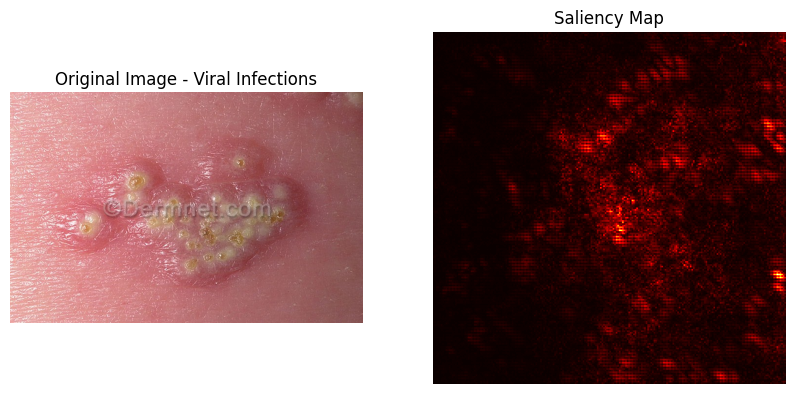

(224, 224)


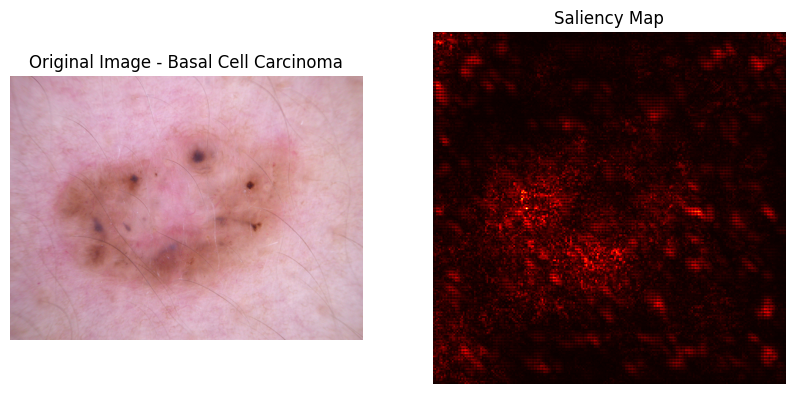

(224, 224)


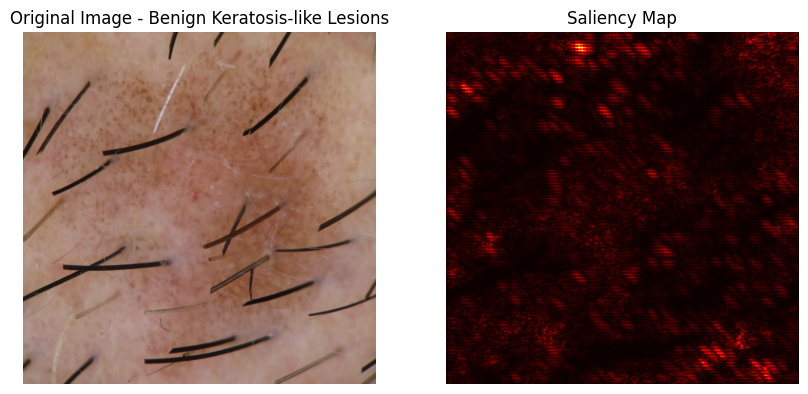

(224, 224)


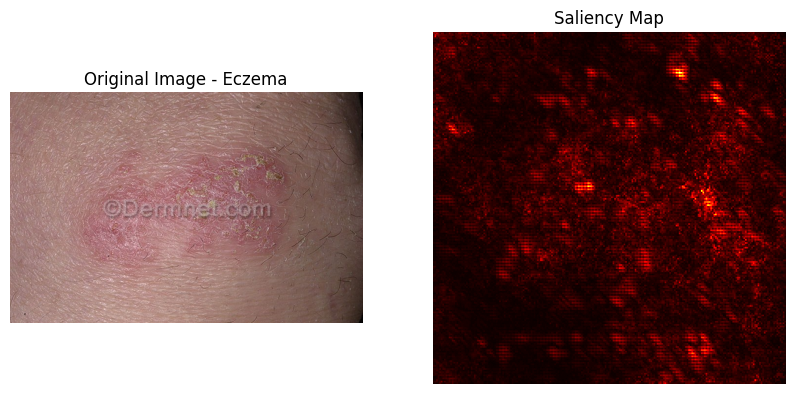

(224, 224)


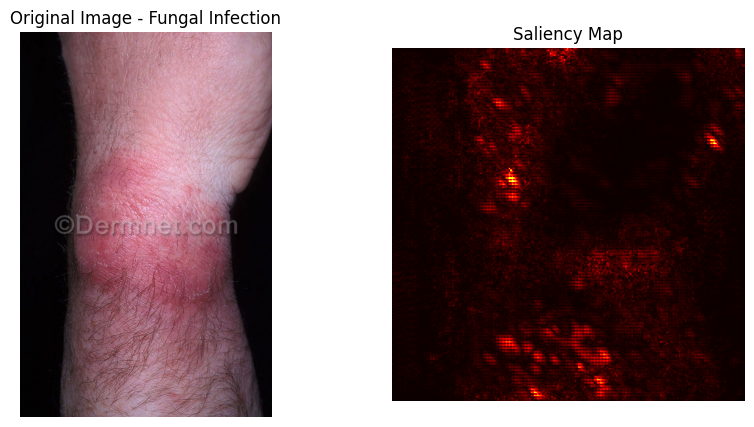

(224, 224)


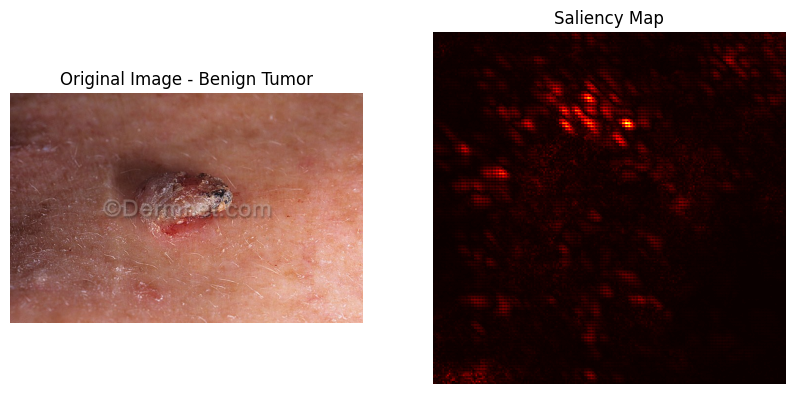

(224, 224)


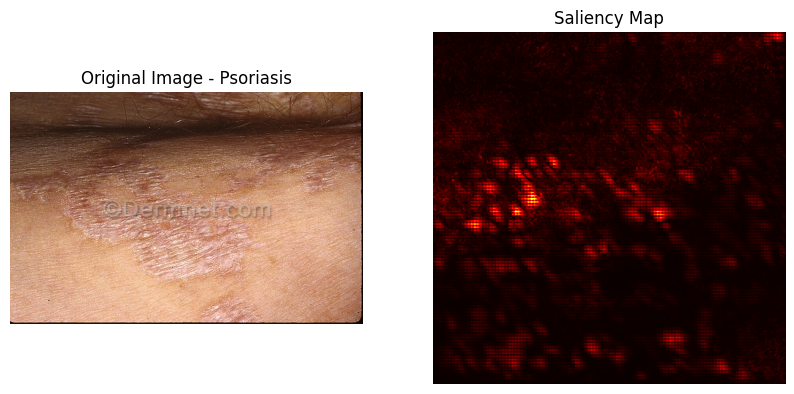

(224, 224)


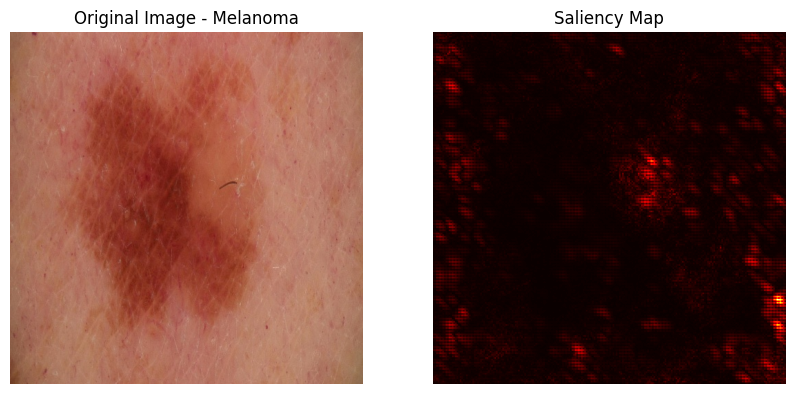

(224, 224)


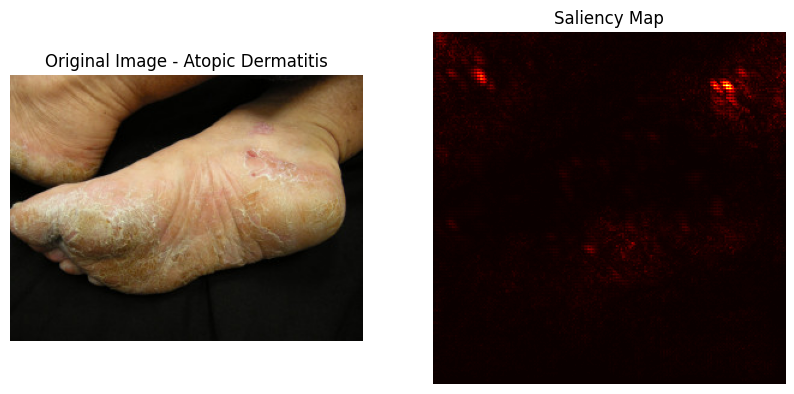

(224, 224)


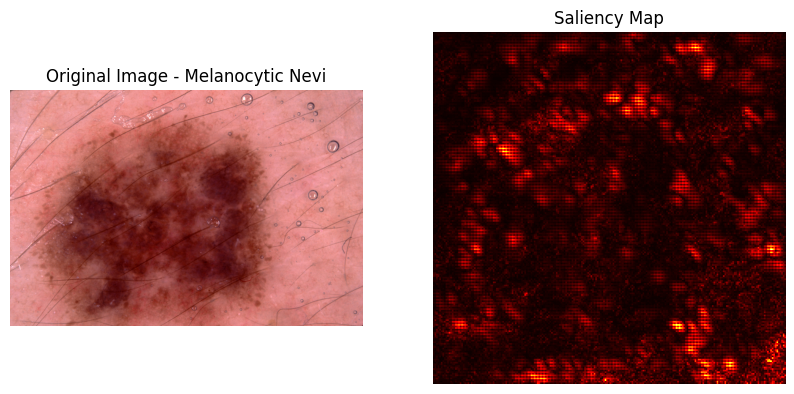

In [ ]:
for class_name, image_path in class_to_image.items():
    image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to("cuda")
    saliency = compute_saliency_map(cnn_model, image_tensor, target_class=0)  # Example target class
    visualize_saliency(class_name, image_path, saliency)

##Grad-CAM


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAMForSiamese:
    def __init__(self, model, target_layer_name):
        """
        Initialize Grad-CAM for a specific model and target layer.
        Args:
            model (nn.Module): The Siamese model to analyze.
            target_layer_name (str): The name of the target layer for Grad-CAM.
        """
        self.model = model
        self.target_layer = dict([*model.backbone.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def compute_cam(self, input_tensor):
        """
        Compute the Grad-CAM heatmap for a single input using embedding mean.
        Args:
            input_tensor (torch.Tensor): Input tensor (batch_size=1, 3, H, W).
        Returns:
            np.ndarray: Grad-CAM heatmap.
        """
        # Forward pass
        device = input_tensor.device
        backbone_features = self.model.backbone(input_tensor)

        # Compute the output embedding
        combined_features = torch.cat((backbone_features, torch.zeros(1, 4, device=device)), dim=1)
        embedding = self.model.fc(combined_features)  # Final embedding

        # Use the mean of the embedding as the scalar objective
        objective = embedding.mean()
        objective.backward(retain_graph=True)

        # Check activation shape
        batch_size, num_tokens, channels = self.activations.size()  # Transformer layer activations: (batch_size, num_tokens, channels)
        image_height, image_width = 224, 224  # Replace with your input image size
        patch_size = 16  # Replace with your ViT patch size
        height = image_height // patch_size
        width = image_width // patch_size
        print(num_tokens)
        print(height*width)


        assert height * width == num_tokens-1, "Mismatch between tokens and spatial dimensions."

        # Reshape activations and gradients to (batch_size, channels, height, width)
        self.activations = self.activations.permute(0, 2, 1).view(batch_size, channels, height, width)
        self.gradients = self.gradients.permute(0, 2, 1).view(batch_size, channels, height, width)

        # Compute Grad-CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling
        cam = (weights * self.activations).sum(dim=1).squeeze()  # Weighted sum of activations
        cam = F.relu(cam).cpu().numpy()  # ReLU to keep positive contributions

        # Normalize the heatmap
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)
        return cam



    def visualize(self, cam, original_image):
        """
        Visualize the Grad-CAM heatmap over the original image.
        Args:
            cam (np.ndarray): Grad-CAM heatmap.
            original_image (PIL.Image): Original input image.
        """
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.axis("off")
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(original_image)
        plt.imshow(cam, cmap="jet", alpha=0.5)  # Overlay CAM on the image
        plt.axis("off")
        plt.title("Grad-CAM")
        plt.show()


In [ ]:

vit_grad_cam = GradCAMForSiamese(vit_model, target_layer_name='blocks.11')

In [ ]:
target_layer_name =
grad_cam = GradCAM(cnn_model, target_layer_name)

In [ ]:


for class_name, image_path in class_to_image.items():
    # Preprocess the input image
    image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)  # Add batch dimension
    cam = vit_grad_cam.compute_cam(image_tensor)
    original_image = Image.open(image_path).convert("RGB")
    # Visualize Grad-CAM heatmap
    grad_cam.visualize(cam, original_image)

197
196


RuntimeError: shape '[1, 768, 14, 14]' is invalid for input of size 151296

##Integrated Gradients

In [ ]:
from captum.attr import IntegratedGradients
from torchvision.models import resnet50

# Initialize model and Integrated Gradients
model = resnet50(pretrained=True)
model.eval()
ig = IntegratedGradients(model)

# Compute attributions
def compute_integrated_gradients(image_tensor, target_class):
    baseline = torch.zeros_like(image_tensor)  # Black baseline image
    attributions, delta = ig.attribute(image_tensor, baseline, target=target_class, return_convergence_delta=True)
    return attributions.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Visualize attributions
def visualize_integrated_gradients(image_path, attributions):
    original_image = np.array(Image.open(image_path).convert("RGB")) / 255.0
    attributions = np.abs(attributions).sum(axis=-1)  # Aggregate channels
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(attributions, cmap="hot")
    plt.axis("off")
    plt.title("Integrated Gradients")
    plt.show()

# Example usage
attributions = compute_integrated_gradients(image_tensor, target_class=243)  # Example target class
visualize_integrated_gradients(image_path, attributions)
